# PLN Project 1 - Ruled-base Text Classification

In [5]:
# Packages and Frameworks
import pandas as pd
import string
import re

import spacy
nlp = spacy.load("pt_core_news_sm")

import nltk
from nltk.metrics.agreement import AnnotationTask
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download("stopwords")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Loading dataset
url = "https://raw.githubusercontent.com/franciellevargas/HateBR/refs/heads/main/dataset/HateBR.csv"

df = pd.read_csv(url)

print(df.columns)
df

Index(['id', 'comentario', 'anotator1', 'anotator2', 'anotator3',
       'label_final', 'links_post', 'account_post'],
      dtype='object')


,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
...,...,...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada ...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6996,6997,A melhor maneira de unir a direita do mundo to...,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6997,6998,Vcs são lutadores. Sejam protegidos.,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a...",0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro


### Annotators concordade analysis (krisppendorff Coefficient)

In [7]:
# Annotators Concordance Analysis

label = df.loc[:, "label_final"]
annot1 = df.loc[:, "anotator1"]
annot2 = df.loc[:, "anotator2"]
annot3 = df.loc[:, "anotator3"]

annots = []
for row in range(len(df)):
    annots.append(("annot1", label[row], annot1[row]))
    annots.append(("annot2", label[row], annot2[row]))
    annots.append(("annot3", label[row], annot3[row]))

task = AnnotationTask(data=annots)

print(f"Krippendorff's Alpha: {task.alpha():.3f}")

Krippendorff's Alpha: 0.771


### Lexical Analysis - Tokens, Types, stopwords and emojis

In [8]:
# Helper function and variable to separate consecutive emojis or consecutive emojis+words
# and determine wheter a sequence of alphanumeric chars is an emoji
emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]", flags=re.UNICODE)

def separate_emojis(text):
    return emoji_pattern.sub(r' \g<0> ', text)

In [9]:
# Tokens and Types already without punctuation including supposedly "stop words" and emojis

# Bag of words
corpus = " ".join(df["comentario"].astype(str))
corpus = separate_emojis(corpus)

tokens = word_tokenize(corpus)

filtered_tokens = []
for token in tokens:
    if token in string.punctuation:
        continue
    token = re.sub(r"\.\*", "", token)
    parts = re.split(f"[{re.escape(string.punctuation)}]", token)
    filtered_tokens.extend([p.lower() for p in parts if p])

types = set(filtered_tokens)

print(filtered_tokens[400:680])

print(f"Number of tokens without punctuation: {len(filtered_tokens)}")
print(f"Number of types: {len(types)}")

['carla', 'zambelli', 'obrigado', 'pelas', 'informações', 'de', 'sempre', '🇧', '🇷', '💙', 'rapariga', 'de', 'cego', 'quem', 'essa', 'vagabunda', 'pensa', 'que', 'é', 'pra', 'dar', 'pitaco', 'aqui', 'dentro', 'vagabunda', 'bachelet', 'vc', 'como', 'todo', 'bom', 'esquerdista', 'é', 'uma', 'hipócrita', 'tenha', 'pena', 'de', 'vc', 'e', 'do', 'seu', 'povo', 'q', 'mulher', 'ordinária', 'realmente', 'uma', 'verdadeira', 'hipócrita', 'simples', 'são', 'canalhas', 'que', 'amam', 'o', 'dinheiro', 'do', 'povo', '👊', '🏾', '🇧', '🇷', 'acabou', 'pra', 'eles', 'aí', 'ficam', 'nesta', 'choradeira', 'de', '🚮', 'esgoto', 'lama', 'podre', 'isso', 'eh', 'o', 'comunismo', 'povo', 'na', 'merda', 'é', 'eles', 'de', 'boa', 'canalhas', '👊', '🏾', 'pq', 'é', 'uma', 'vaca', 'porca', 'asquerosa', '🤮', '🤮', '🤮', 'realmente', 'a', 'hipocrisia', 'está', 'estampada', 'na', 'cara', 'de', 'pau', '👎', '👎', '👎', '👎', 'ridícula', 'vai', 'cuidar', 'da', 'sua', 'vida', 'deve', 'ter', 'pena', 'dela', 'quando', 'descobrir', 'o

In [10]:
# Top N Most frequent tokens/words (without punctuation)
top_n_value = 20

# 1 - Maintaining "stop words"
freq_dist = FreqDist(filtered_tokens)
most_common_tokens = freq_dist.most_common(top_n_value)

print(f"Top {top_n_value} tokens more frequent, including stopwords and emojis:")
for token, freq in most_common_tokens:
    print(f"{token}: {freq}")

# stopwords in top 100 tokens
print("\n=================================\n")

stopwords = nltk.corpus.stopwords.words("portuguese")
top_tokens = [token for token, _ in FreqDist(filtered_tokens).most_common(100)]
stopwords_in_top = [t for t in top_tokens if t in stopwords]

print("Stopwords in top 100 most common tokens:", stopwords_in_top)

# 2 - Removing "stop words" but maintaining emojis
print("\n=================================\n")

filtered_tokens = [token for token in filtered_tokens if token not in stopwords or emoji_pattern.fullmatch(token)]
filtered_tokens = [t for t in filtered_tokens if t.strip() != "" and t not in {"️", "\u200d"}]

freq_dist = FreqDist(filtered_tokens)
most_common_tokens = freq_dist.most_common(top_n_value)

print(f"Top {top_n_value} tokens more frequent, excluding stopwords and inluding emojis:")
for token, freq in most_common_tokens:
    print(f"{token}: {freq}")

Top 20 tokens more frequent, including stopwords and emojis:
que: 2845
o: 2655
de: 2632
e: 2436
a: 2296
👏: 2036
é: 1762
não: 1500
do: 1277
🇷: 951
🇧: 948
um: 899
com: 847
da: 804
se: 801
para: 729
😂: 720
esse: 679
uma: 654
os: 651


Stopwords in top 100 most common tokens: ['que', 'o', 'de', 'e', 'a', 'é', 'não', 'do', 'um', 'com', 'da', 'se', 'para', 'esse', 'uma', 'os', 'tem', 'em', 'mais', 'no', 'na', 'por', 'essa', 'isso', 'só', 'ser', 'ele', 'está', 'as', 'como', 'muito', 'eu', 'meu', 'ela', 'mas', 'quem', 'nosso', 'já', 'são', 'foi', 'você', 'dos', 'sua', 'seu', 'mesmo', 'sem', 'ou', 'ao', 'pelo', 'me', 'esses', 'estão', 'nos', 'até', 'nem']


Top 20 tokens more frequent, excluding stopwords and inluding emojis:
👏: 2036
🇷: 951
🇧: 948
😂: 720
❤: 545
pra: 528
presidente: 520
brasil: 501
deus: 411
vai: 390
parabéns: 365
vc: 353
bolsonaro: 284
🤮: 283
🤣: 271
povo: 259
lula: 254
bem: 243
país: 239
todos: 231


### Preprocessing Pipeline

In [11]:
def preprocess(text, lemmatize=False):

    text = str(text).lower()
    text = separate_emojis(text)

    # Tokenization and optional lemmatization
    if lemmatize:
        # Lemmatization with context-aware
        doc = nlp(text)
        tokens = [token.lemma_ if not emoji_pattern.fullmatch(token.text) else token.text
                for token in doc]
    else:
        tokens = word_tokenize(text)

    tokens = [t for t in tokens if t.strip() != "" and t not in {"️", "\u200d"}]

    filtered_tokens = []
    for token in tokens:
        if token in string.punctuation:
            continue
        token = re.sub(r"\.\*", "", token)
        parts = re.split(f"[{re.escape(string.punctuation)}]", token)
        filtered_tokens.extend([p.lower() for p in parts if p])

    # Remove stopwords and keep emojis
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords or emoji_pattern.fullmatch(token)]

    return filtered_tokens

### Sentiment Analysis Process using PT lexicon and Emojis

In [12]:
# Emoji sentiment analysis without sentece context
# Getting a dict (emoji_sentiment_dict) with emoji as key and sentiment associated with sentiment

dataset_emojis = "Emoji_Sentiment_Data_v1.0.csv"
df_emojis = pd.read_csv(dataset_emojis, usecols=["Emoji", "Unicode codepoint", "Positive", "Negative", "Neutral"])

print(df_emojis.head())

# Function to determine dominant sentiment
def dominant_sentiment(row):
    sentiments = {"Positive": 1, "Neutral": 0, "Negative": -1}
    max_sent = row[["Positive", "Neutral", "Negative"]].idxmax()
    return sentiments[max_sent]

df_emojis["Sentiment"] = df_emojis.apply(dominant_sentiment, axis=1)
emoji_sentiment_dict = dict(zip(df_emojis["Emoji"], df_emojis["Sentiment"]))

# dict with emoji sentiments
print(df_emojis.head())
for k, v in list(emoji_sentiment_dict.items())[:5]:
    print(k, v)

  Emoji Unicode codepoint  Negative  Neutral  Positive
0     😂           0x1f602      3614     4163      6845
1     ❤            0x2764       355     1334      6361
2     ♥            0x2665       252     1942      4950
3     😍           0x1f60d       329     1390      4640
4     😭           0x1f62d      2412     1218      1896
  Emoji Unicode codepoint  Negative  Neutral  Positive  Sentiment
0     😂           0x1f602      3614     4163      6845          1
1     ❤            0x2764       355     1334      6361          1
2     ♥            0x2665       252     1942      4950          1
3     😍           0x1f60d       329     1390      4640          1
4     😭           0x1f62d      2412     1218      1896         -1
😂 1
❤ 1
♥ 1
😍 1
😭 -1


In [13]:
# PT Lexicon with sentiments associated to words (lexicon)

lexicon_file = "SentiLex-flex-PT02.txt"

lexicon = {}
with open(lexicon_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            # Split words
            words_part, rest = line.split(".", 1)
            words = words_part.split(",")
            words = [word.lower() for word in words]

            # Extract polarities (some words have multiple POL:Nx fields)
            polarities = [int(m) for m in re.findall(r"POL:N\d=(-?\d+)", rest)]
            if not polarities:
                polarities = [0]
            
            for word in words:
                lexicon[word] = polarities
            
        except:
            continue

# Lexicon
for k, v in list(lexicon.items())[:10]:
    print(k, v)

à-vontade [1]
abafada [-1]
abafado [-1]
abafadas [-1]
abafados [-1]
abafante [-1]
abafantes [-1]
abaixada [-1]
abaixado [-1]
abaixadas [-1]


In [14]:
# SentiLex Lexicon with lemmatization
lexicon_lem = {}

for word, polarity in lexicon.items():
    doc = nlp(word)
    if doc and doc[0]:
        lemma = doc[0].lemma_
        if lemma not in lexicon_lem:
            lexicon_lem[lemma] = polarity

print(f"Original Lexicon Size: {len(lexicon)}")
print(f"Lexicon Lemmatized Size: {len(lexicon_lem)}")

Original Lexicon Size: 79296
Lexicon Lemmatized Size: 31589


In [15]:
# Commmentary sentece sentiments
def sentiment_score(tokens, lexicon, emoji_dict):

    score = 0
    count = 0

    for token in tokens:
        if token in lexicon:
            # mean of sentiments of that set of words
            token_score = sum(lexicon[token]) / len(lexicon[token])
            score += token_score
            count += 1
        elif token in emoji_dict:
            score += emoji_dict[token]
            count += 1

    sentiment = score / count if count != 0 else 0

    return sentiment


### Results of Testing Sentiment Analysis

In [16]:
test_comments = df["comentario"].iloc[:100]

results = pd.DataFrame()

for comment in test_comments:
    tokens_no_lem = preprocess(comment, lemmatize=False)
    tokens_lem = preprocess(comment, lemmatize=True)
    
    score_no_lem = sentiment_score(tokens_no_lem, lexicon, emoji_sentiment_dict)
    score_lem = sentiment_score(tokens_lem, lexicon_lem, emoji_sentiment_dict)
    
    results = pd.concat([results, pd.DataFrame([{
        "comment": comment,
        "tokens_no_lemmatize": tokens_no_lem,
        "tokens_lemmatize": tokens_lem,
        "score_no_lemmatize": score_no_lem,
        "score_lemmatize": score_lem
    }])], ignore_index=True)

# Results
for _, r in results.iloc[80:96, :].iterrows():
    print("Comment:", r["comment"])
    print("Tokens (no lemmatize):", r["tokens_no_lemmatize"])
    print("Tokens (lemmatize):   ", r["tokens_lemmatize"])
    print("Sentence Sentiment (no lemmatize):", r["score_no_lemmatize"])
    print("Sentence Sentiment (lemmatize):   ", r["score_lemmatize"])
    print("-----------------------------------------------------")

Comment: Essa gentalha tirando uma de vítima. Vão derrubar Já já. Coitados. Deus é Deus!
Tokens (no lemmatize): ['gentalha', 'tirando', 'vítima', 'vão', 'derrubar', 'coitados', 'deus', 'deus']
Tokens (lemmatize):    ['gentalha', 'tirar', 'vítima', 'ir', 'derrubar', 'coitado', 'deus', 'deus']
Sentence Sentiment (no lemmatize): -0.75
Sentence Sentiment (lemmatize):    -0.4
-----------------------------------------------------
Comment: Sua TONTA SAFADA
Tokens (no lemmatize): ['tonta', 'safada']
Tokens (lemmatize):    ['tonta', 'safar']
Sentence Sentiment (no lemmatize): -1.0
Sentence Sentiment (lemmatize):    -0.5
-----------------------------------------------------
Comment: Mentirosa enganadora 👎👎👎
Tokens (no lemmatize): ['mentirosa', 'enganadora', '👎', '👎', '👎']
Tokens (lemmatize):    ['mentiroso', 'enganadora', '👎', '👎', '👎']
Sentence Sentiment (no lemmatize): -1.0
Sentence Sentiment (lemmatize):    -1.0
-----------------------------------------------------
Comment: Cachorra safada o 

### Rule-Based Classification

In [25]:
# Splitting data and preprocess and sentiment score application on training data
""" If lemmatization, change lemmatize to TRUE and, in sentiment_score, lexicon_lem"""

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df["filtered_texts"] = train_df["comentario"].apply(lambda x: preprocess(x, lemmatize=False))
train_df["sentiment_score"] = train_df["filtered_texts"].apply(lambda t: sentiment_score(t, lexicon_lem, emoji_sentiment_dict))

In [18]:
# Build of cosine similarity seed
neg_threshold = -0.66

neg_comments = train_df[train_df["sentiment_score"] <= neg_threshold]["filtered_texts"]
seed_neg_comments = neg_comments.sample(min(len(neg_comments), 50), random_state=30).tolist()

seeds_texts = [" ".join(c) for c in seed_neg_comments]

# Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(seeds_texts)
X_seeds = vectorizer.transform(seeds_texts)

In [19]:
# Loading offensive words

offensive_file = "OffensiveWordsPT.txt"

offensive_words = []
with open(offensive_file, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            # Split words
            words = line.split(",")
            offensive_words.extend(words)
        except:
            continue

# list of offensive words
print(offensive_words[150:200])

['estúpida', 'fake', 'falação', 'falso', 'fdp', 'fedida', 'fedido', 'fedor', 'fedorenta', 'feia', 'feio', 'feiosa', 'feioso', 'feioza', 'feiozo', 'fela', 'felacao', 'felação', 'fenda', 'fiada', 'filha da puta', 'filho da puta', 'filhos da puta', 'puta', 'finasterida', 'foda', 'fodao', 'fode', 'fodida', 'fodido', 'fodão', 'fds', 'foda-se', 'fornica', 'fria', 'fudecao', 'fudendo', 'fudeção', 'fudida', 'fudido', 'furada', 'furado', 'furao', 'furnica', 'furnicar', 'furo', 'furona', 'furão', 'gaiata', 'gaiato']


In [20]:
# Offensive Lemmatized Words Set
offensive_words_lem = set()

for word in offensive_words:
    doc = nlp(word)
    if doc and doc[0]:
        offensive_words_lem.add(doc[0].lemma_)

print(f"Original Offensive Words: {len(offensive_words)}")
print(f"Offensive Lemmatized Words: {len(offensive_words_lem)}")

Original Offensive Words: 470
Offensive Lemmatized Words: 405


In [29]:
# Classification rules pipeline

def classify_comment(original_text, tokens, use_lemma=False, use_cosine=False, threshold_cosine=0.7):
    
    # Choose lexicons based on use_lemma flag
    current_lexicon = lexicon_lem if use_lemma else lexicon
    current_offensive_list = offensive_words_lem if use_lemma else offensive_words

    # Rule 1: Strong negative sentiment
    s = sentiment_score(tokens, current_lexicon, emoji_sentiment_dict)
    if s == -1:
        return 1

    # Rule 2: Offensive words
    if any(tok in current_offensive_list for tok in tokens):
        return 1

    # Rule 3: PoS heuristics (negative adjectives or verbs)
    doc = nlp(original_text)
    neg_adjs_verbs = []

    if use_lemma:
        neg_adjs_verbs = [
            token for token in doc
            if token.pos_ in {"ADJ", "VERB"}
            and token.lemma_ in current_lexicon
            and sum(current_lexicon[token.lemma_])/len(current_lexicon[token.lemma_]) < 0
        ]
    else:
        neg_adjs_verbs = [
            token for token in doc
            if token.pos_ in {"ADJ", "VERB"}
            and token.text in current_lexicon
            and sum(current_lexicon[token.text])/len(current_lexicon[token.text]) < 0
        ]
    
    # threshold: at least 2 negative ADJ or VERB
    if len(neg_adjs_verbs) >= 2:
        return 1

    # Rule 4: Optional cosine similarity to negative seeds
    if use_cosine:
        text = " ".join(tokens)
        vect = vectorizer.transform([text])
        sim = cosine_similarity(vect, X_seeds).max()
        if sim >= threshold_cosine:
            return 1

    # Otherwise, not offensive
    return 0

### Text-based Rules Classification Evaluation

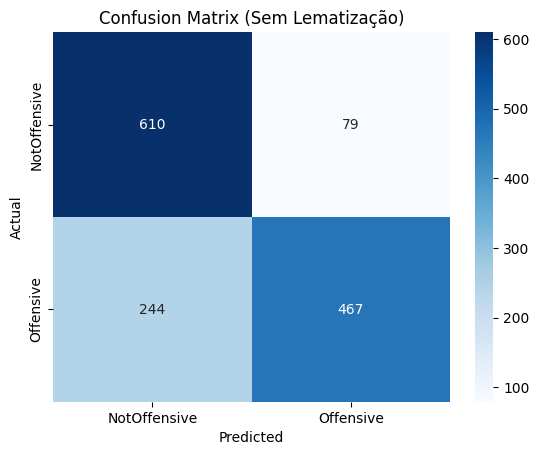

              precision    recall  f1-score   support

NotOffensive       0.71      0.89      0.79       689
   Offensive       0.86      0.66      0.74       711

    accuracy                           0.77      1400
   macro avg       0.78      0.77      0.77      1400
weighted avg       0.79      0.77      0.77      1400



In [30]:
# Evaluation

RUN_WITH_LEMMATIZATION = False

test_df["filtered_texts"] = test_df["comentario"].apply(lambda x: preprocess(x, lemmatize=RUN_WITH_LEMMATIZATION))

test_df["prediction"] = test_df.apply(
    lambda row: classify_comment(
        row["comentario"],
        row["filtered_texts"],
        use_lemma=RUN_WITH_LEMMATIZATION,
        use_cosine=True
    ),
    axis=1
)

# Confusion Matrix
cm = confusion_matrix(test_df["label_final"], test_df["prediction"])
title = "Confusion Matrix (Com Lematização)" if RUN_WITH_LEMMATIZATION else "Confusion Matrix (Sem Lematização)"

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotOffensive", "Offensive"],
            yticklabels=["NotOffensive", "Offensive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()

# Final Classification Report
report = classification_report(test_df["label_final"], test_df["prediction"], target_names=["NotOffensive", "Offensive"])
print(report)